In [91]:
%load_ext autoreload
%autoreload 2

In [1]:
from hydra import initialize, compose
from omegaconf import OmegaConf
from pathlib import Path

import sys 
sys.path.insert(0, "../../src")

import numpy as np
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from dataloader import SingleCellAndCodexDataset 
from model import FlowMatchingModelWrapper
from torch.utils.data import random_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

plt.rcParams['figure.figsize'] = (3, 3) 

Initialize configuration 

In [2]:
with initialize(config_path="../../configs/"):
    # Step 2: Compose the configuration
    config_dict = compose(config_name="train")  # replace 'config' with your actual config name

/tmp/ipykernel_2660329/4061682399.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../../configs/"):


Dataset

In [3]:
dataset = SingleCellAndCodexDataset(config_dict.datamodule.rna_adata_path, 
                                        config_dict.datamodule.codex_adata_path, 
                                        config_dict.datamodule.label_columns, 
                                        config_dict.datamodule.obsm_key_rna, 
                                        config_dict.datamodule.obsm_key_codex) 

In [5]:
dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=64,
                                            shuffle=True,
                                            num_workers=4)

/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
for batch in dataloader:
    pass

KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 88519

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/nfs/homedirs/pala/scportrait_ot/notebooks/tonsilitis_results/../../src/dataloader.py", line 138, in __getitem__
    X_rna_batch = torch.from_numpy(self.X_rna[idx_rna]).float()
  File "/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/pandas/core/frame.py", line 4102, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 88519


Dataloaders

In [4]:
model = FlowMatchingModelWrapper(input_dim=dataset.input_dim,
                                hidden_dim=config_dict.model.hidden_dim,
                                num_hidden_layers=config_dict.model.num_hidden_layers,
                                time_embedding_dim=config_dict.model.time_embedding_dim,
                                source_condition_dim=dataset.source_dim, 
                                use_batchnorm=config_dict.model.use_batchnorm,
                                sigma=config_dict.model.sigma, 
                                flavor=config_dict.model.flavor, 
                                learning_rate=config_dict.model.learning_rate, 
                                weight_decay=config_dict.model.weight_decay, 
                                distance=config_dict.model.distance)

## Collect trained model

In [22]:
# ckpts = torch.load("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/experiements/wild-paper-4/checkpoints/last.ckpt")
ckpts = torch.load("/nfs/homedirs/pala/scportrait_ot/project_folder/experiements/checkpoints/wild-paper-4/checkpoints/last.ckpt")

In [23]:
model.load_state_dict(ckpts["state_dict"])

<All keys matched successfully>

### Read CODEX data

In [24]:
adata_codex = sc.read_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/codex/cellfeaturization_results_tonsilitis_processed.h5ad")

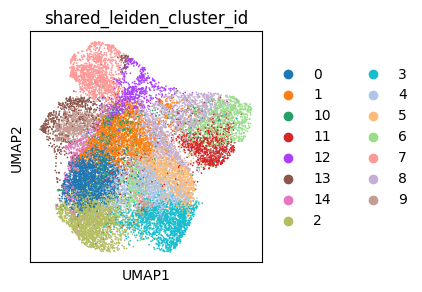

In [25]:
sc.pl.umap(adata_codex, color="shared_leiden_cluster_id")

### Read scRNA-seq data

In [26]:
# adata_scrnaseq = sc.read_h5ad("/lustre/groups/ml01/workspace/alessandro.palma/scportrait/data/scrnaseq/sce_converted_processed_discovery.h5ad")
adata_scrnaseq = sc.read_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery.h5ad")
adata_scrnaseq.obsm["X_umap"] = adata_scrnaseq.obsm["UMAP"].values

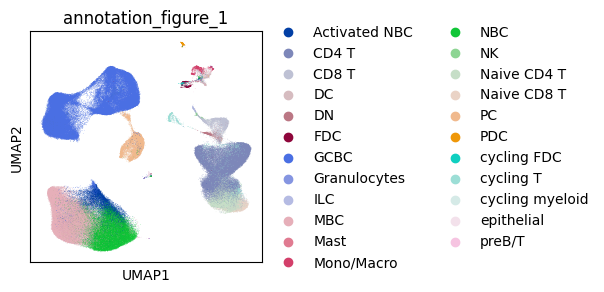

In [27]:
sc.pl.umap(adata_scrnaseq, color="annotation_figure_1")

## Analyze assignment 

Write a sequential looper through the CODEX dataset

In [28]:
# Step 1: Wrap the CODEX data in a PyTorch Dataset
class CodexDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data.X).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# Step 2: Define cluster assignment via nearest neighbors
def cluster_assignment(X_hat, X_true, true_annot, n_neighs=1):
    nn_model = KNeighborsClassifier(n_neighbors=n_neighs, algorithm='auto')
    nn_model.fit(X_true, true_annot)
    indices = nn_model.predict(X_hat)
    return indices

### Perform annotation

In [29]:
# Step 3: Prepare data and loader
codex_dataset = CodexDataset(adata_codex)
codex_loader = DataLoader(codex_dataset, batch_size=1000, shuffle=False)

real_annot = np.array(adata_scrnaseq.obs.annotation_figure_1)
X_true = adata_scrnaseq.obsm["HARMONY"]  # assumed (n_cells_rna, n_features)

# Step 4: Run inference and assignment in batches
assigned_annots = []

for batch in codex_loader:
    X_codex = batch  # already a torch tensor
    X_rna_hat = model.pushforward(
        x0=X_codex,
        n_timesteps=2,
        solver="dopri5"
    ).detach().cpu().numpy()

    batch_annots = cluster_assignment(X_rna_hat, X_true, real_annot, n_neighs=5)
    
    assigned_annots.append(batch_annots)
    
# Step 5: Concatenate all annotations
assigned_annots = np.concatenate(assigned_annots)

adata_codex.obs["cell_type"] = assigned_annots

/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

Examine results

Activated NBC


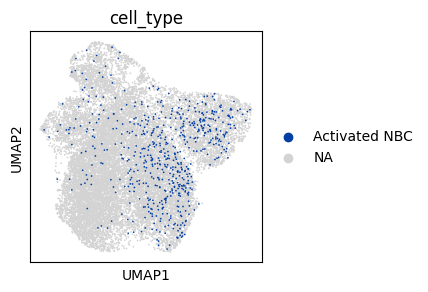

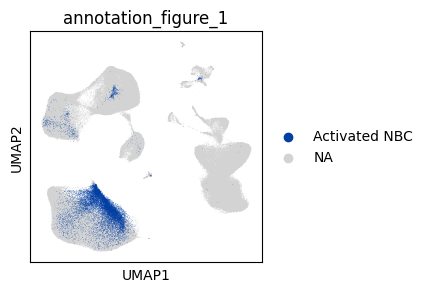

CD4 T


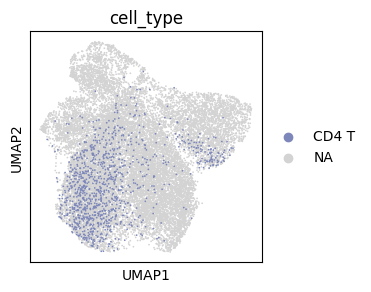

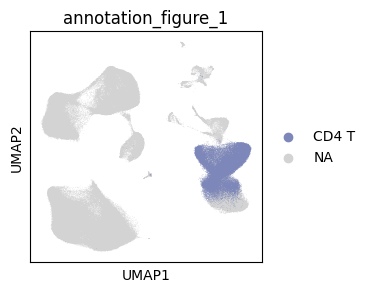

CD8 T


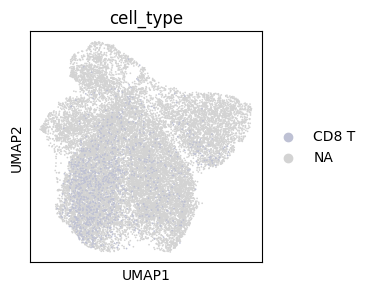

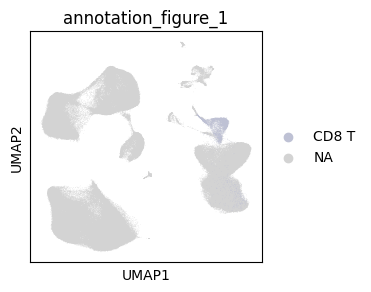

DC


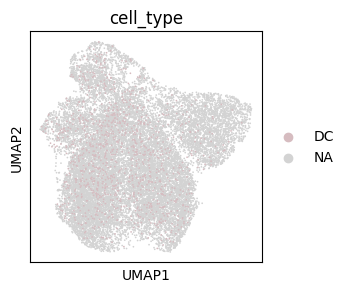

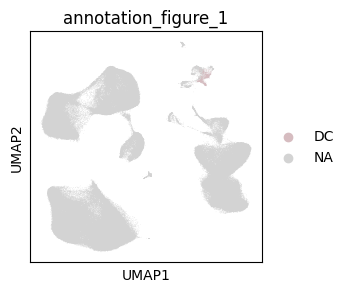

DN


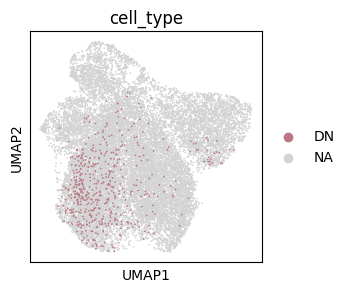

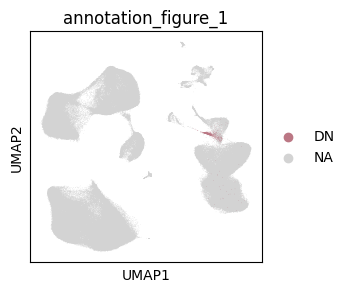

FDC


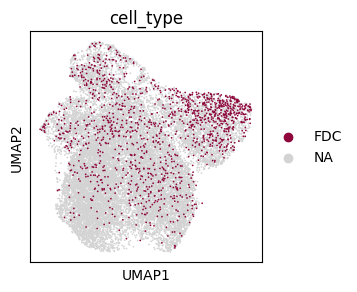

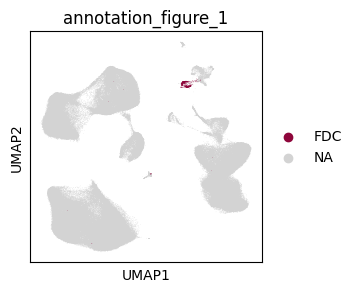

GCBC


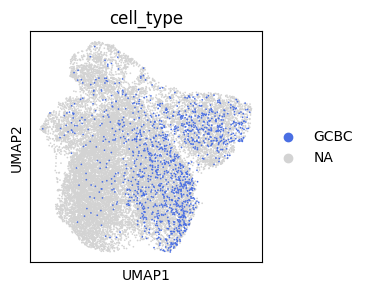

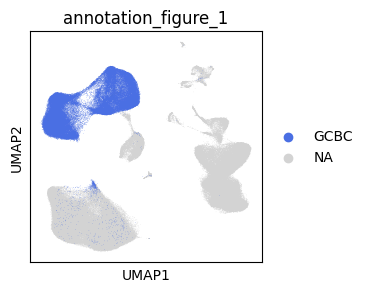

Granulocytes


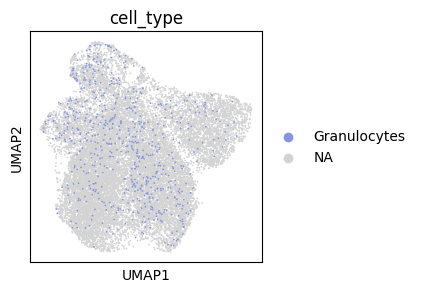

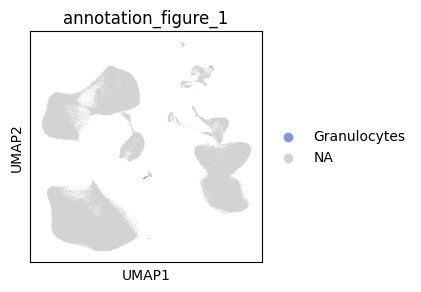

ILC


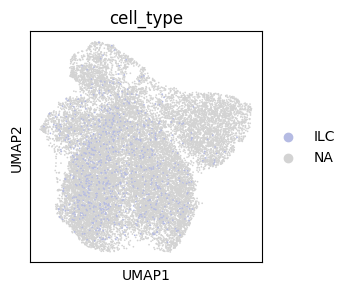

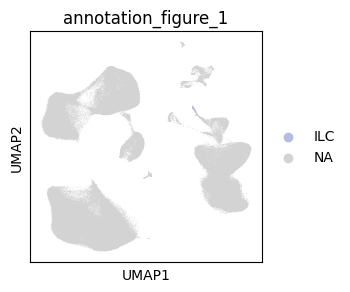

MBC


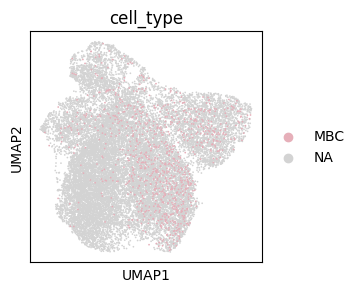

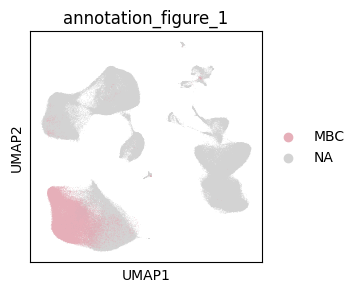

Mast


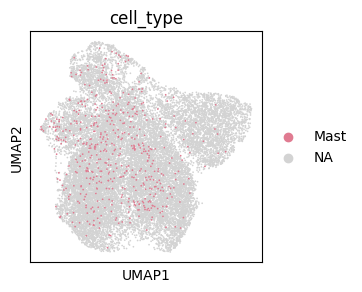

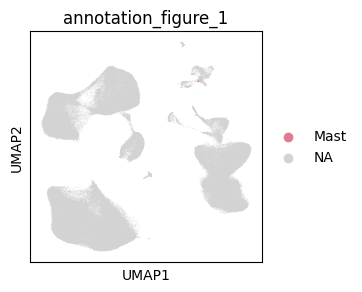

Mono/Macro


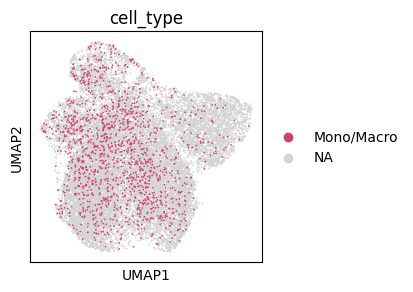

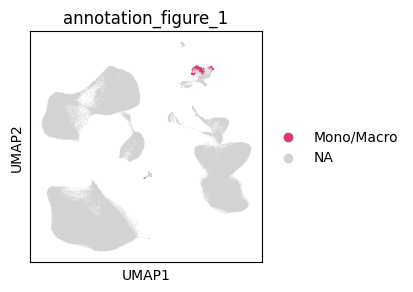

NBC


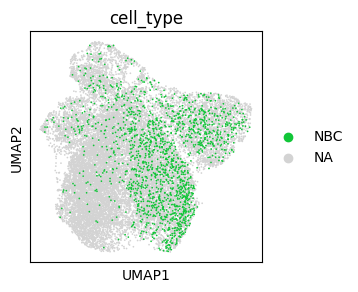

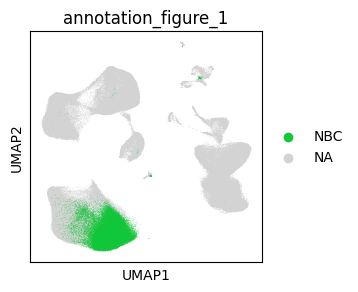

NK


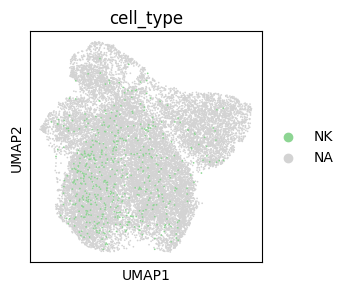

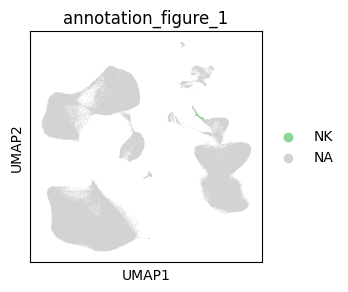

Naive CD4 T


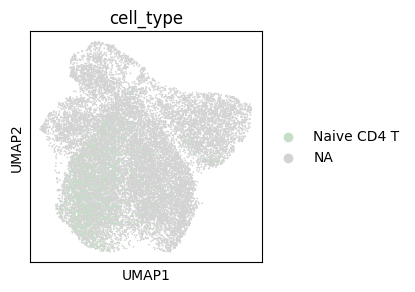

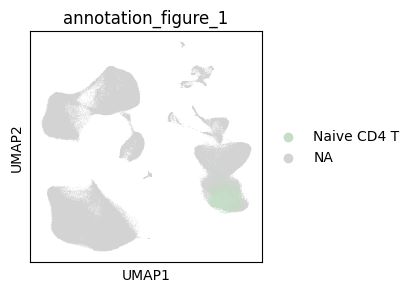

Naive CD8 T


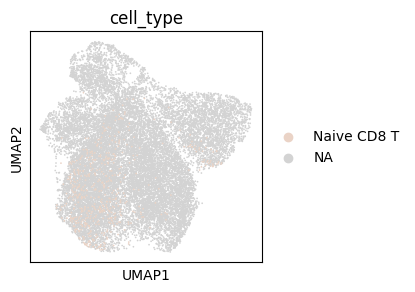

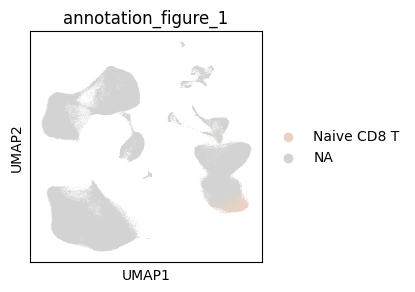

PC


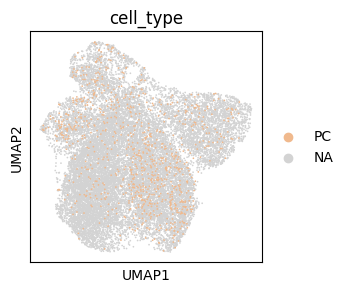

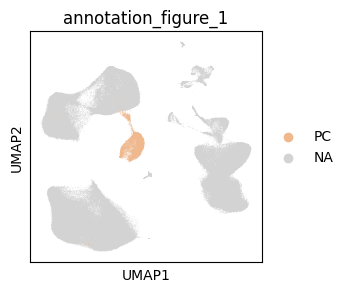

PDC


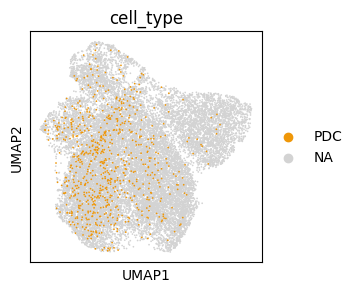

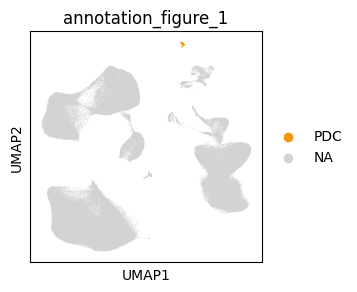

cycling FDC


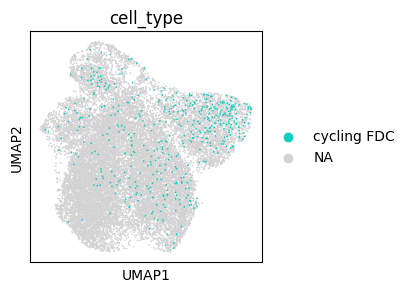

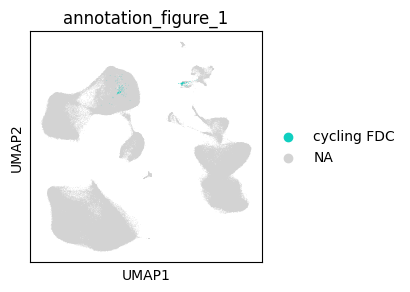

cycling T


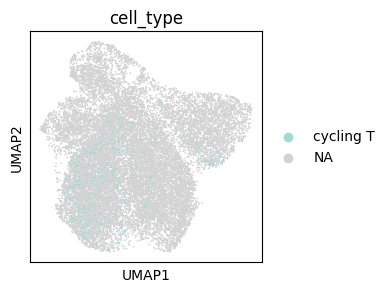

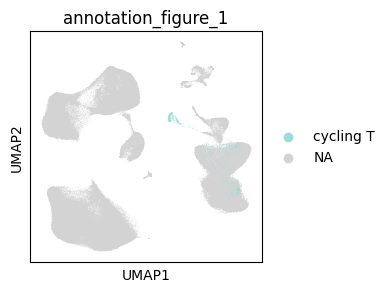

cycling myeloid


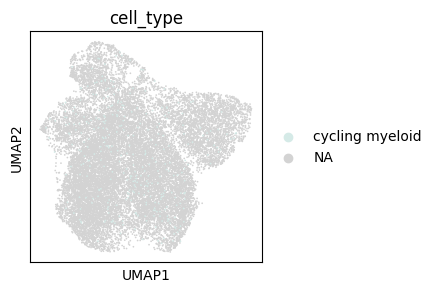

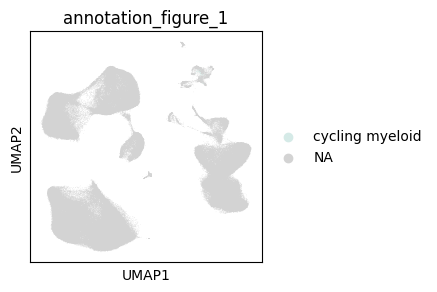

epithelial


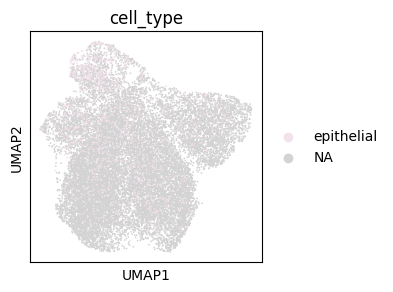

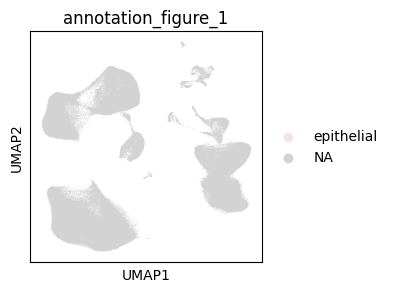

preB/T


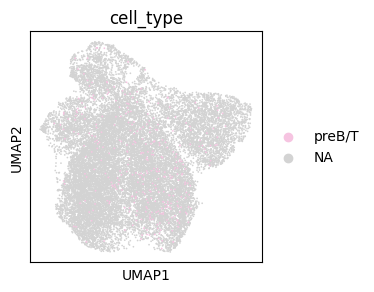

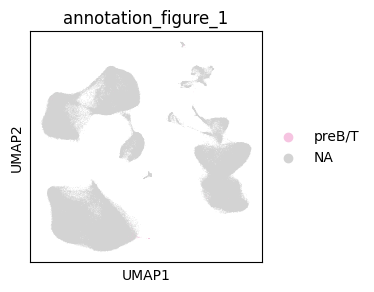

In [30]:
for cl in np.unique(adata_codex.obs.cell_type):
    print(cl)
    sc.pl.umap(adata_codex,color="cell_type", groups=[cl])
    sc.pl.umap(adata_scrnaseq, color="annotation_figure_1", groups=[cl])

## Add decoding

In [52]:
# adata_scrnaseq = sc.read_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery.h5ad")
# adata_scrnaseq.X = adata_scrnaseq.layers["X_counts"].copy()

# adata_scrnaseq = sc.read_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery_hvgs.h5ad")

adata_scrnaseq = sc.read_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/scrnaseq/sce_converted_processed_discovery_reduced.h5ad")

In [53]:
from dataloader import EmbeddingDecoderDataset
from decoding_modules import DecoderFromHarmony
from pathlib import Path
from scvi.distributions import NegativeBinomial

In [54]:
# decoder_model = DecoderFromHarmony(input_dim=50, 
#                                    output_dim=55, 
#                                    dims=[64, 64],
#                                    batch_norm=False, 
#                                    dropout=False,
#                                    dropout_p=0.0, 
#                                    batch_encoding=False, 
#                                    batch_encoding_dim=None,
#                                    learning_rate=1e-3
#                                   )
# decoder_model.load_state_dict(torch.load("/nfs/homedirs/pala/scportrait_ot/project_folder/experiements/decoder_55/honest-dawn-3/checkpoints/last.ckpt")["state_dict"])

# decoder_model = DecoderFromHarmony(input_dim=50, 
#                                    output_dim=1765, 
#                                    dims=[256, 256],
#                                    batch_norm=False, 
#                                    dropout=False,
#                                    dropout_p=0.0, 
#                                    batch_encoding=False, 
#                                    batch_encoding_dim=None,
#                                    learning_rate=1e-3
#                                   )
# decoder_model.load_state_dict(torch.load("/nfs/homedirs/pala/scportrait_ot/project_folder/experiements/decoder_hvg/brisk-sun-1/checkpoints/last.ckpt")["state_dict"])

decoder_model = DecoderFromHarmony(input_dim=50, 
                                   output_dim=37378, 
                                   dims=[256, 256],
                                   batch_norm=False, 
                                   dropout=False,
                                   dropout_p=0.0, 
                                   batch_encoding=False, 
                                   batch_encoding_dim=None,
                                   learning_rate=1e-3
                                  )
decoder_model.load_state_dict(torch.load("/nfs/homedirs/pala/scportrait_ot/project_folder/experiements/decoder_all/fearless-music-1/checkpoints/last.ckpt")["state_dict"])

<All keys matched successfully>

Mean library sizes per class

In [55]:
library_sizes_per_cond = {}

for cond in np.unique(adata_scrnaseq.obs.annotation_figure_1):
    library_sizes_per_cond[cond] = adata_scrnaseq[adata_scrnaseq.obs.annotation_figure_1==cond].X.sum(1).mean()

In [56]:
rna_hat_decoded = []

for batch in codex_loader:
    # Predict RNA 
    X_codex = batch  # already a torch tensor
    X_rna_hat = model.pushforward(
        x0=X_codex,
        n_timesteps=2,
        solver="dopri5"
    )

    # Assign cluster
    batch_annots = cluster_assignment(X_rna_hat.detach().cpu().numpy(), X_true, real_annot, n_neighs=5)
    sampled_ls_batch = []
    for annot in batch_annots:
        sampled_ls_batch.append(library_sizes_per_cond[annot])
    sampled_ls_batch = torch.tensor(sampled_ls_batch).unsqueeze(1)

    # Decode
    mu_hat = decoder_model.decoder(X_rna_hat)
    mu_hat = F.softmax(mu_hat, dim=1)
    px = NegativeBinomial(mu=mu_hat * sampled_ls_batch, theta=torch.exp(decoder_model.theta))
    rna_hat_decoded.append(px.sample())

/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/nfs/staff-ssd/pala/miniconda3/envs/sc_exp_design/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning:

In [57]:
rna_hat_decoded = torch.cat(rna_hat_decoded, axis=0).numpy()

In [58]:
adata_codex.obsm["X_rna_predicted"] = rna_hat_decoded

In [59]:
# adata_codex.write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/codex/expression_prediction/tonsilitis_55_markers.h5ad")
# adata_codex.write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/codex/expression_prediction/tonsilitis_hvgs.h5ad")
adata_codex.write_h5ad("/nfs/homedirs/pala/scportrait_ot/project_folder/data/codex/expression_prediction/tonsilitis_all.h5ad")